### Imports

In [118]:
import pandas as pd
import nltk, re, string
import numpy as np
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn import svm
from nltk.corpus import stopwords

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import StratifiedKFold
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re, collections
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import words as w

from nltk.corpus import *
from nltk.collocations import *
from string import punctuation
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

### Preprocess Data

Read the csv file and make a dataframe.
- For training: Randomize and Divide it into 80:20 partitions

In [119]:
def load_Dataset(run="train"):
    df = pd.read_csv("train.csv")
    df = df[df["Comment"].notnull()]
    df.apply(np.random.permutation)
    if run=="train":
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    elif run=="test":
        df_train = df
        df_test = pd.read_csv("test_with_solutions.csv")
    elif run=="test1":
        df_train = df
        df_test = pd.read_csv("impermium_verification_labels.csv")
        df_test.describe()
        #del(df_test['ID'])
    return df_train, df_test

### Tokenization

This function takes a text and does the following to return the tokens:
* Use nltk's TweetTokenizer to get tokens
* Use wordNetLemmatizer for lemmatization
* Use porterStemmer to stem the resulting tokens

In [122]:
def build_tokens(text):
    tweetTokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tweetTokenizer.tokenize(text)
    #tokens = preprocess(text, lowercase=True)
    #tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    #tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    return tokens


Lemmatizing, Stemming and custom preprocessing reduced the accuracy. Tweettokenizer worked better.

## Function to plot Confusion matrix

In [123]:
def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Pipeline and Adding Custom features

#### Adding additional features

Few custom features are added - percentage of bad words in a sentence as listed in the bad words file and the compound, negative and positive values from vader sentiment analysis and number of words in comments.

In [124]:
class AdditionalFeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def get_feature_names(self):
        return (['percent_bad','vader_compound','num_words','vader_neg','vader_pos'])
    
    def num_bad(self, df):
        #get number of words in each sentence
        num_words = [len(word) for word in df]
        
        #get percent of abusive words in each sentence
        with open("list_of_abuses.txt", "r") as abuse_list:
            abuses = abuse_list.read().split()
            num_abuses = 0
            for abuse in abuses:
                num_abuses += 1
            # number of badwords in list of abuses
            num_bad = [np.sum([word.lower().count(abuse) for abuse in abuses])
                                                for word in df]
            norm_bad = np.array(num_bad) / np.array(num_words, dtype=np.float)
        return norm_bad
    
    def num_words(self,df):
        #get number of words in each sentence
        num_words = [len(word) for word in df]
        return num_words
    
    def vader_helper(self, df):
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['compound'])
        return vader_feature
    
    def vader_helper_neg(self, df):
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['neg'])
        return vader_feature
    
    def vader_helper_pos(self, df):
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['pos'])
        return vader_feature
    def transform(self, df, y=None):     
        #add both the features to an array
        X = np.array([self.num_bad(df), self.vader_helper(df),self.num_words(df),self.vader_helper_neg(df),self.vader_helper_pos(df)]).T
        #X = np.array([self.num_bad(df),self.vader_helper(df)]).T
        #X.reshape(-1, 1) #use if only 1 feature
        if not hasattr(self, 'scalar'):
            self.scalar = preprocessing.StandardScaler().fit(X)
        return self.scalar.transform(X)      

    def fit(self, df, y=None):
        return self

The custom features are stacked along with the features got from TF-IDF char and word analyzer

In [125]:
stopwords = ['a','an','the']
def all_features():
    features = []
    custom_features = AdditionalFeatureExtractor() # this class includes my custom features 
    
    vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,6), analyzer= "char", stop_words = stopwords, tokenizer= build_tokens)
    vect1 = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,6), analyzer= "word", stop_words = stopwords, tokenizer= build_tokens)
    
    features.append(('ngram', vect))
    features.append(('ngram1', vect1))
   
    features.append(('custom_features', custom_features))
    return features

SVM Linear classifier gives the best score - better than ensemble

In [126]:
def all_classifiers():
    #clf1 = linear_model.LogisticRegression(C=3, max_iter=3000, tol=1e-8)
    clf3 = svm.SVC(kernel='linear', gamma=1.2, C=1, decision_function_shape="ovo",probability=True)
    #clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet',alpha=0.001, n_jobs=-1)
    #eclf = VotingClassifier(estimators=[('lr',clf1),('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
    return clf3

### Pipeline

In [127]:
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
best_clf = Pipeline([
    ('all', FeatureUnion(all_features())),
    ('ensemble',all_classifiers()),
    ])

### Testing pipeline and custom features

In [128]:
df_train, df_test = load_Dataset()

In [129]:
best_clf.fit(df_train.Comment,df_train.Insult)
predicted = best_clf.predict(df_test.Comment)


In [130]:
accuracy_score(df_test.Insult,predicted)

0.85551330798479086

In [131]:
class_labels = np.sort(df_train.Insult.unique())
lables = [str(i) for i in class_labels]
print(classification_report(df_test.Insult, predicted, target_names=lables))

             precision    recall  f1-score   support

          0       0.89      0.92      0.90       578
          1       0.75      0.69      0.72       211

avg / total       0.85      0.86      0.85       789



In [132]:
best_clf.predict(["Go to hell, you bitch."])

array([1])

#### Testing on validation set - using pipeline and custom

In [133]:
df_train, df_test = load_Dataset("test1")

In [134]:
predictions = best_clf.predict(df_test.Comment)

In [135]:
accuracy_score(df_test.Insult,predictions)

0.74183445190156605

In [136]:
print(classification_report(df_test.Insult, predictions, target_names=lables))

             precision    recall  f1-score   support

          0       0.70      0.88      0.78      1158
          1       0.82      0.60      0.69      1077

avg / total       0.76      0.74      0.74      2235



#### Testing on test set - using pipeline and custom

In [137]:
df_train1, df_test1 = load_Dataset("test")

In [138]:
predictions1 = best_clf.predict(df_test1.Comment)

In [139]:
accuracy_score(df_test1.Insult,predictions1)

0.8658859085757461

In [140]:
print(classification_report(df_test1.Insult, predictions1, target_names=lables))

             precision    recall  f1-score   support

          0       0.89      0.94      0.91      1954
          1       0.79      0.66      0.72       693

avg / total       0.86      0.87      0.86      2647



* 1,6 for both, max_features = all - train 85.29 test 86.36 validation 73.82% --> Vivek's list of abuses
* 1,6 for both, max_features = all - train 85.55 test 86.59 validation 74.18% --> Nihar's list of abuses

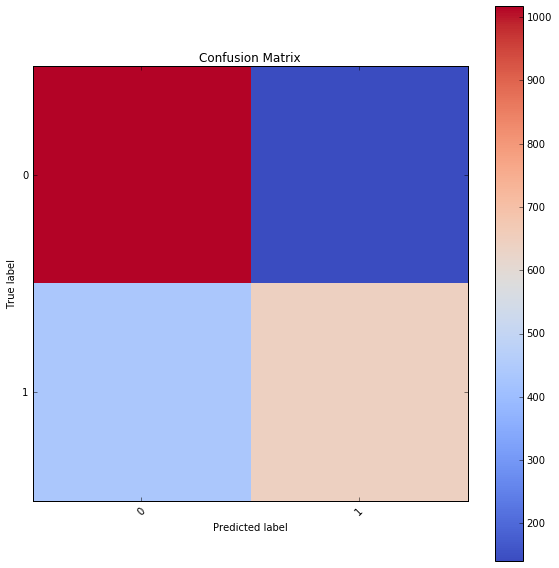

In [141]:
nb_cm = confusion_matrix(df_test.Insult, predictions)
plot_confusion_matrix(nb_cm, "Confusion Matrix", class_labels)